In [1]:
import os
import sys

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import table
from astropy.io import fits
import astropy.units as u

In [3]:
from sherpa.astro import ui

In [4]:
datadir = '/melkor/d1/guenther/downdata/Chandra/RWaur/'
figdir = '/melkor/d1/guenther/Dropbox/my_proposals/Chandra/RW_Aur/'

In [5]:
ui.set_conf_opt("sigma", 1.645)
ui.set_conf_opt("numcores", 24)
ui.set_xsabund("aspl")

In [6]:
data = Table()
data['ObsID'] = ['14539', '17644', '17764', '19980', '21176', '22323', '23100', '23101', '23102',
                 '17764 + 19980', '22323+23100+23101+23102']
data['filestem'] = list(data['ObsID'][:9]) + ['2017', '2019']
data['filesrcB'] = list([ n + '_B_grp.pi' for n in data['ObsID'][:9]]) + ['2017_B_src.pi', '2019_B_src.pi']
data['filebkgB'] = [ n + '_B_bkg.pi' for n in data['filestem']]
data['filesrcA'] = [n.replace('B', 'A') for n in data['filesrcB']]
data['filebkgA'] = [n.replace('B', 'A') for n in data['filebkgB']]
data['year'] = [fits.getval(datadir + n, 'DATE-OBS')[:4] for n in data['filesrcA'][:9]] + ['2017', '2019']

plotorder = [0, 1, 9, 4, 10]

In [7]:
data

ObsID,filestem,filesrcB,filebkgB,filesrcA,filebkgA,year
str23,str5,str14,str14,str14,str14,str4
14539,14539,14539_B_grp.pi,14539_B_bkg.pi,14539_A_grp.pi,14539_A_bkg.pi,2013
17644,17644,17644_B_grp.pi,17644_B_bkg.pi,17644_A_grp.pi,17644_A_bkg.pi,2015
17764,17764,17764_B_grp.pi,17764_B_bkg.pi,17764_A_grp.pi,17764_A_bkg.pi,2017
19980,19980,19980_B_grp.pi,19980_B_bkg.pi,19980_A_grp.pi,19980_A_bkg.pi,2017
21176,21176,21176_B_grp.pi,21176_B_bkg.pi,21176_A_grp.pi,21176_A_bkg.pi,2018
22323,22323,22323_B_grp.pi,22323_B_bkg.pi,22323_A_grp.pi,22323_A_bkg.pi,2019
23100,23100,23100_B_grp.pi,23100_B_bkg.pi,23100_A_grp.pi,23100_A_bkg.pi,2019
23101,23101,23101_B_grp.pi,23101_B_bkg.pi,23101_A_grp.pi,23101_A_bkg.pi,2019
23102,23102,23102_B_grp.pi,23102_B_bkg.pi,23102_A_grp.pi,23102_A_bkg.pi,2019


In [8]:
def read_lcs(obsid, source):
    lcall = Table.read(os.path.join(datadir, '{0}_{1}_lc.fits').format(obsid, source), hdu=1)
    lcsoft = Table.read(os.path.join(datadir, '{0}_{1}_lc_soft.fits').format(obsid, source), hdu=1)
    lchard = Table.read(os.path.join(datadir, '{0}_{1}_lc_hard.fits').format(obsid, source), hdu=1)
    lc = table.hstack([lcall, lcsoft, lchard], table_names=['all', 'soft', 'hard'], metadata_conflicts='silent')
    # time columns are the same for each lightcurve, so remove dublicate entries here for simplicity
    for c in lc.colnames:
        if (('TIME' in c) or ('AREA' in c) or ('EXPOSURE' in c)) and ('all' in c):
            lc.rename_column(c, c[:-4])
            lc.remove_columns([c[:-4] + '_soft', c[:-4] + '_hard'])
    ind  = lc['EXPOSURE'] > 0.
    return lc[ind]
    
lccurves = [[ read_lcs(obsid, t) for t in ['srca', 'srcb']] for obsid in data['ObsID'][:-2]]
for list1 in lccurves:
    for lc in list1:
        lc['t'] = lc['TIME'] - lc['TIME'][0]

In [9]:
# Still need to run http://cxc.harvard.edu/ciao/threads/monitor_photom/ for new data (and put in scripts to rerun)
lcaca = [Table.read(os.path.join(datadir, 'monitor_{0}_lc.fit'.format(obsid)), hdu=1)
         for obsid in data['ObsID'][1:-2]]

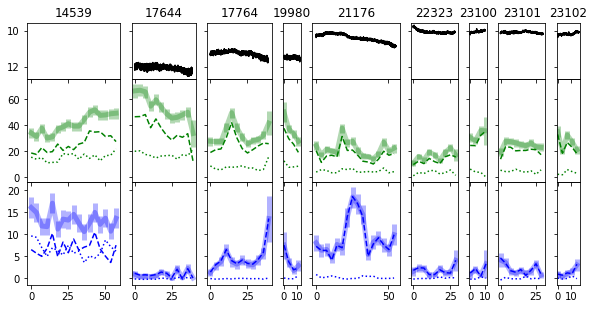

In [10]:
fig = plt.figure(figsize=(8, 13))

nlc = len(lccurves)

width = np.array([lc[0]['t'][-1] for lc in lccurves])
width = width / width.sum() * 0.8  # last factor is scale factor to make space for label left of plot
dy = [0.11, 0.11, 0.06]
ypos = [0.1, 0.21, 0.32]
axes = []
for y in range(3):
    for x in range(len(lccurves)):
        kwargs = {}
        if y != 0:
            kwargs['sharex'] = axes[x]
        if x != 0:
            kwargs['sharey'] = axes[y * nlc]
        axes.append(fig.add_axes((.1 + np.sum(width[0:x]) + x * 0.02, ypos[y], width[x], dy[y]), **kwargs))

for j in range(3):
    for i in range(1, nlc):
        plt.setp(axes[j * nlc + i].get_yticklabels(), visible=False)
        
for j in [1, 2]:
    for i in range(nlc):
        plt.setp(axes[j * nlc + i].get_xticklabels(), visible=False)
    
for i, obsid in enumerate(data['ObsID'][:-2]):
    axes[0 * nlc + i].errorbar(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_all'] * 1e3, lccurves[i][0]['ERR_RATE_all'] * 1e3, 
                             label='0.3-9.0 keV', color='b', lw=5, alpha=0.3)
    axes[0 * nlc + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_soft'] * 1e3, 
                         color='b', ls=':', label='0.3-1.0 keV')
    axes[0 * nlc + i].plot(lccurves[i][0]['t']/1e3, lccurves[i][0]['NET_RATE_hard'] * 1e3, 
                         color='b', ls='--', label='1.0-9.0 keV')
    axes[1 * nlc + i].errorbar(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_all'] * 1e3, lccurves[i][1]['ERR_RATE_all'] * 1e3,
                             label='0.3-9.0 keV', color='g', lw=5, alpha=0.3)
    axes[1 * nlc + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_soft'] * 1e3, 
                         color='g', ls=':', label='0.3-1.0 keV')
    axes[1 * nlc + i].plot(lccurves[i][1]['t']/1e3, lccurves[i][1]['NET_RATE_hard'] * 1e3, 
                     color='g', ls='--', label='1.0-9.0 keV')
    axes[2 * nlc + i].set_title(obsid)
    # ACA data
    if i > 0:
        axes[2 * nlc + i].plot((lcaca[i - 1]['time'] - lcaca[i - 1]['time'][0]) / 1e3, lcaca[i - 1]['mag'], color='k')
   
axes[2 * nlc].invert_yaxis()


In [11]:
for row in data:
    ui.load_data(row['filestem'] + '_B', datadir + row['filesrcB'])
    ui.load_bkg(row['filestem'] + '_B', datadir + row['filebkgB'])                  
    ui.load_data(row['filestem'] + '_A', datadir + row['filesrcA'])
    ui.load_bkg(row['filestem'] + '_A', datadir + row['filebkgA'])                     

read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B.rmf
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B_bkg.rmf
read background file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B_bkg.pi
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_B_bkg.rmf
read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_A.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_A.rmf
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_A_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_A_bkg.rmf
read background file /melkor/d1/guenther/downdata/Chandra/RWaur/14539_A_bkg.pi
read ARF (background) file /melkor/d1/gu

read background file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_B_bkg.pi
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_B_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_B_bkg.rmf
read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A.rmf
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A_bkg.rmf
read background file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A_bkg.pi
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/23101_A_bkg.rmf
read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/23102_B.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/23102_B.rmf
read ARF (background) file /melkor/d1/gu

In [12]:
# Note sure this is needed, but is certainly messes up the boll indices
#for i in ui.list_data_ids():
#    if i % 10 != 6:
#        ui.ignore_bad(i)

In [13]:
ui.ignore(None, 0.3)
ui.ignore(9., None)

## The spectrum of RW Aur B
This needs tobe modeled, because we will use it as a component in the RW Aur A model to account for the contamination of the RW Aur A data by signal coming from RW Aur B.

Text(0.5, 1, 'RW Aur B')

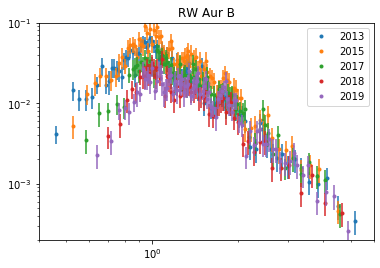

In [14]:
for i in ui.list_data_ids():
    if i[-2:] == '_B':
        ui.group_counts(i, 15)
    
for i in plotorder:
    ui.plot_data(data['filestem'][i] + '_B', overplot=True)
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 6)
ax.set_ylim(2e-4, 0.1)
ax.legend(ax.get_lines(), data['year'][plotorder])
ax.set_title('RW Aur B')

In [15]:
years = list(set(data['year']))
years.sort()

b_models = {y: ui.xsphabs(name='Ba_'+y) * (ui.xsvapec(name='Bv1_'+y) + ui.xsvapec(name='Bv2_'+y)) for y in years}

for row in data:
    ui.set_source(row['filestem'] + '_B', b_models[row['year']])

In [16]:
for bo in b_models.values():
    for elem in ['C', 'N', 'O','Ne', 'Fe', 'Si', 'Mg']:
        setattr(bo.rhs.rhs, elem, getattr(bo.rhs.lhs, elem))
    bo.rhs.lhs.kT = 0.5
    bo.rhs.rhs.kT = 2.0

In [17]:
ui.show_model()

Model: 14539_B
apply_rmf(apply_arf((54482.855450192 * (xsphabs.Ba_2013 * (xsvapec.Bv1_2013 + xsvapec.Bv2_2013)))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Ba_2013.nH   thawed            1            0       100000 10^22 atoms / cm^2
   Bv1_2013.kT  thawed          0.5       0.0808       68.447        keV
   Bv1_2013.He  frozen            1            0         1000           
   Bv1_2013.C   frozen            1            0         1000           
   Bv1_2013.N   frozen            1            0         1000           
   Bv1_2013.O   frozen            1            0         1000           
   Bv1_2013.Ne  frozen            1            0         1000           
   Bv1_2013.Mg  frozen            1            0         1000           
   Bv1_2013.Al  frozen            1            0         1000           
   Bv1_2013.Si  frozen            1            0         1000           
 

In [18]:
to_fit_B = [row['filestem']+'_B' for row in data if row['filestem']==row['ObsID']]

In [19]:
# Leaving these independent can actually lead to the worse chi^2, so no reason to suspect that nH is changeing
# Fix to reduce number of parameters in fit

for y in years[1:]:
    b_models[y].lhs.nH = b_models[years[0]].lhs.nH

ui.fit(*to_fit_B)

Datasets              = '14539_B', '17644_B', '17764_B', '19980_B', '21176_B', '22323_B', '23100_B', '23101_B', '23102_B'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 4.6827e+10
Final fit statistic   = 496.205 at function evaluation 404
Data points           = 420
Degrees of freedom    = 399
Probability [Q-value] = 0.00064369
Reduced statistic     = 1.24362
Change in statistic   = 4.6827e+10
   Ba_2013.nH     0.610414     +/- 0.054745    
   Bv1_2013.kT    0.240786     +/- 0.0153526   
   Bv1_2013.norm   0.000704334  +/- 0.000212304 
   Bv2_2013.kT    1.80793      +/- 0.11707     
   Bv2_2013.norm   0.000268475  +/- 1.31804e-05 
   Bv1_2015.kT    2.0829       +/- 0.218615    
   Bv1_2015.norm   0.000248875  +/- 2.9703e-05  
   Bv2_2015.kT    0.779298     +/- 0.0351525   
   Bv2_2015.norm   0.000296586  +/- 4.58842e-05 
   Bv1_2017.kT    0.462932     +/- 0.0978583   
   Bv1_2017.norm   0.000180323  +/- 5.74402e-05 
   Bv2_2017.kT    1.68668 

In [20]:
for row in data:
    ui.subtract(row['filestem']+'_B')

In [21]:
# It seems that joining the temperature of both components should work well
for y in years[1:]:
    b_models[y].rhs.lhs.kT = b_models[years[0]].rhs.lhs.kT
    b_models[y].rhs.rhs.kT = b_models[years[0]].rhs.rhs.kT
    
ui.fit(*to_fit_B)

Datasets              = '14539_B', '17644_B', '17764_B', '19980_B', '21176_B', '22323_B', '23100_B', '23101_B', '23102_B'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1131.17
Final fit statistic   = 415.266 at function evaluation 128
Data points           = 420
Degrees of freedom    = 407
Probability [Q-value] = 0.377853
Reduced statistic     = 1.02031
Change in statistic   = 715.899
   Ba_2013.nH     1.04711      +/- 0.0449024   
   Bv1_2013.kT    0.174342     +/- 0.0034461   
   Bv1_2013.norm   0.00885207   +/- 0.00198625  
   Bv2_2013.kT    1.54268      +/- 0.0400411   
   Bv2_2013.norm   0.000306671  +/- 1.52333e-05 
   Bv1_2015.norm   0.0141304    +/- 0.00316933  
   Bv2_2015.norm   0.000476748  +/- 2.42942e-05 
   Bv1_2017.norm   0.0083307    +/- 0.00195572  
   Bv2_2017.norm   0.000379354  +/- 1.91573e-05 
   Bv1_2018.norm   0.00778985   +/- 0.00182133  
   Bv2_2018.norm   0.000255841  +/- 1.62422e-05 
   Bv1_2019.norm   0.00793162  

The spectra are so remarkebly similar, it's almost uncanning, given the change in flux that I see in the lightcurve. It seems that all the variability I see within one observation washes out when I add the data fomr the entire observation together. It might actually we worth investigating, if there are any changes at all! The norms are significantly different, though.

I tried freeing abundances, but this is so close to defauls, there really is no reason to set them to anything else than 1.

Text(0.5, 1, 'RW Aur B')

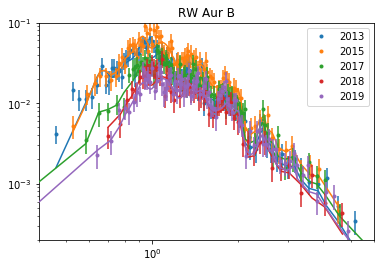

In [22]:
# Use the following line to change the size of the figure
# fig = plt.figure(figsize=(15,10))
mplcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,j  in enumerate(plotorder):
    ui.plot_fit(data['filestem'][j] + '_B', overplot=True, color=mplcolors[i])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 6)
ax.set_ylim(2e-4, 0.1)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('RW Aur B')

## The spectrum of RW Aur A

Text(0.5, 1, 'RW Aur A')

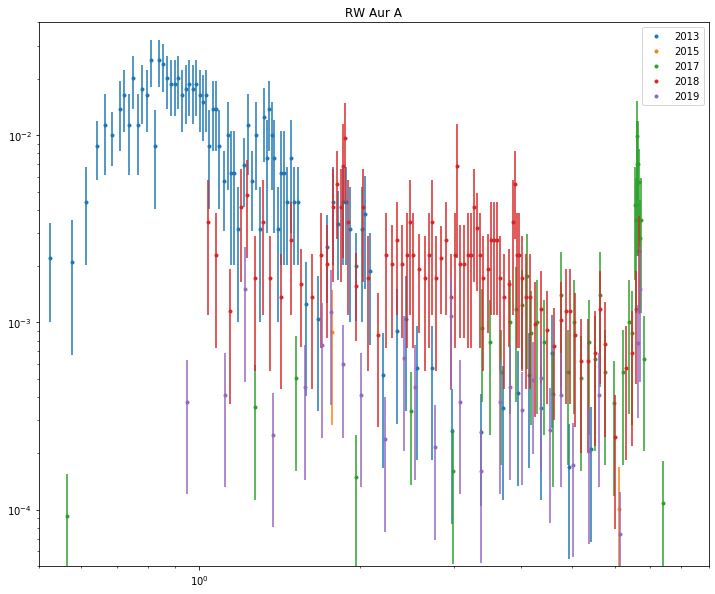

In [23]:
fig = plt.figure(figsize=(12, 10))
for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(data['filestem'][i] + '_A', overplot=True)
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.5, 9)
ax.set_ylim(5e-5, 0.04)
ax.legend(ax.get_lines(), data['year'][plotorder])
ax.set_title('RW Aur A')

In [24]:
to_fit_A = [row['filestem']+'_A' for row in data if row['filestem']==row['ObsID']]

In [25]:
scaleB = ui.scale1d(name='scaleB')

# Freeze everything in B models except the scale
for row in data:
    b_mod = b_models[row['year']]
    ui.set_bkg_source(row['filestem'] + '_A', scaleB * b_mod)
    
    for model in [b_mod.lhs, b_mod.rhs.lhs, b_mod.rhs.rhs]:
        for par in model.pars:
            par.frozen=True

In [27]:
# Some of the 2019 datasets have too few counts to make a fit at all. So, use merged dataset here.
# If the count numbers are so small, the error is dominated by counting statistics and not by systematics
# of coadding spectra.
ui.fit_bkg('14539_A', '17644_A', '2017_A', '21176_A', '2019_A')

Datasets              = '14539_A', '17644_A', '2017_A', '21176_A', '2019_A'
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 48981.5
Final fit statistic   = 84.3363 at function evaluation 4
Data points           = 118
Degrees of freedom    = 117
Probability [Q-value] = 0.990088
Reduced statistic     = 0.720823
Change in statistic   = 48897.2
   scaleB.c0      0.064177     +/- 0.00423206  


Text(0.5, 1, 'Bkg for RW Aur A')

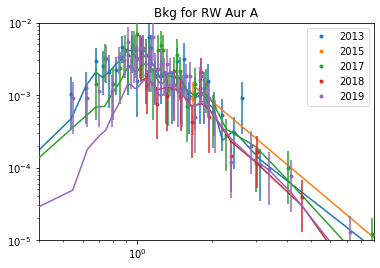

In [28]:
# Use the following line to change the size of the figure
#fig = plt.figure(figsize=(15,10))

for i,j  in enumerate(plotorder):
    ui.plot_bkg_fit(data['filestem'][j] + '_A', overplot=True, color=mplcolors[i])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 9)
ax.set_ylim(1e-5, 0.01)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('Bkg for RW Aur A')

In [30]:
scaleB.c0.frozen = True

In [31]:
a_models = {y: ui.xsphabs(name='Aa_'+y) * (ui.xsvapec(name='Av1_'+y) + ui.xsvapec(name='Av2_'+y)) for y in years}

for row in data:
    a_mod = a_models[row['year']]
    ui.set_source(row['filestem'] + '_A', a_mod)
    for elem in ['C', 'N', 'O','Ne', 'Fe', 'Si', 'Mg']:
        setattr(a_mod.rhs.rhs, elem, getattr(a_mod.rhs.lhs, elem))
    a_mod.lhs.nH.frozen = False

In [32]:
# Set of kT=20 from Skinner & Guedel for 2013 data, fix kT as in Schneider et al for 2015 data
a_models['2013'].rhs.lhs.Ne.frozen = False
a_models['2013'].rhs.lhs.Fe.frozen = False
a_models['2013'].rhs.rhs.kT.frozen = True
a_models['2013'].rhs.rhs.kT.frozen = 20.

a_models['2015'].rhs.lhs.kT = a_models['2013'].rhs.lhs.kT
a_models['2015'].rhs.rhs.kT = a_models['2013'].rhs.rhs.kT

a_models['2017'].rhs.lhs.Fe.frozen = False
a_models['2017'].rhs.rhs.kT.frozen = True
a_models['2017'].rhs.rhs.kT = 20.

# Set models close to final to speed up convergence when running the notebook again
a_models['2017'].lhs.nH = 45
a_models['2017'].rhs.lhs.kT = 1
a_models['2017'].rhs.lhs.Fe = 50

In [ ]:
for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.ungroup(i)

ui.set_stat('cash')

In [33]:
ui.ignore(None, .4)
ui.ignore(8., None)
        
ui.fit('14539_A')
#ui.fit('17644_A')
ui.fit('17764_A', '19980_A')
ui.fit('21176_A')
ui.fit('22323_A', '23100_A', '23101_A', '23102_A')

Dataset               = 14539_A
Method                = levmar
Statistic             = cash
Initial fit statistic = 1.42332e+07
Final fit statistic   = -222.367 at function evaluation 491
Data points           = 712
Degrees of freedom    = 706
Change in statistic   = 1.42334e+07
   Aa_2013.nH     0.0751867    +/- 0.0542927   
   Av1_2013.kT    9.92188      +/- 0           
   Av1_2013.Ne    0.0247972    +/- 6.69016     
   Av1_2013.Fe    0.0118647    +/- 1.10675     
   Av1_2013.norm   6.79464e-09  +/- 1.8272e-05  
   Av2_2013.norm   0.000163873  +/- 1.93729e-05 
Datasets              = '17764_A', '19980_A'
Method                = levmar
Statistic             = cash
Initial fit statistic = 1.57552e+06
Final fit statistic   = 1089.87 at function evaluation 125
Data points           = 1916
Degrees of freedom    = 1911
Change in statistic   = 1.57443e+06
   Aa_2017.nH     40.7273      +/- 5.78398     
   Av1_2017.kT    1.36554      +/- 0.181664    
   Av1_2017.Fe    12.4972      +/- 7.354

In [77]:
print(a_models['2015'])

(xsphabs.Aa_2015 * (xsvapec.Av1_2015 + xsvapec.Av2_2015))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Aa_2015.nH   thawed           45            0       100000 10^22 atoms / cm^2
   Av1_2015.kT  linked     0.228196        expr: Av1_2013.kT        keV
   Av1_2015.He  frozen            1            0         1000           
   Av1_2015.C   frozen            1            0         1000           
   Av1_2015.N   frozen            1            0         1000           
   Av1_2015.O   frozen            1            0         1000           
   Av1_2015.Ne  frozen            1            0         1000           
   Av1_2015.Mg  frozen            1            0         1000           
   Av1_2015.Al  frozen            1            0         1000           
   Av1_2015.Si  frozen            1            0         1000           
   Av1_2015.S   frozen            1            0         10

In [68]:
# Freeze parameters that we want to take from the 2013 fit at the values
# fitted above to the 2013 data
a_models['2015'].rhs.lhs.kT.frozen = True
a_models['2015'].rhs.rhs.kT.frozen = True

ui.fit('17644_A')

a_models['2015'].rhs.lhs.kT = a_models['2013'].rhs.lhs.kT
a_models['2015'].rhs.rhs.kT = a_models['2013'].rhs.rhs.kT

Dataset               = 17644_A
Method                = levmar
Statistic             = cash
Initial fit statistic = 722543
Final fit statistic   = 984.365 at function evaluation 53
Data points           = 20
Degrees of freedom    = 17
Change in statistic   = 721559
   Av1_2015.Fe    2.34738      +/- 31.0975     
   Av1_2015.norm   81.4483      +/- 30.7752     
   Av2_2015.norm   8.53842e-05  +/- 0.000107272 


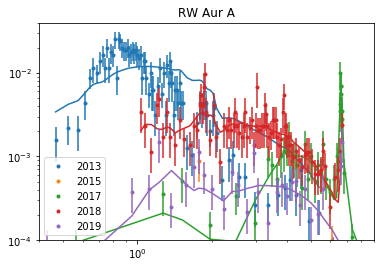

In [35]:
# Use the following line to change the size of the figure
#fig = plt.figure(figsize=(15,10))

for i in ui.list_data_ids():
    if i[-2:] == '_A':
        ui.group_counts(i, 5)

for i,j  in enumerate(plotorder):
    ui.plot_fit(data['filestem'][j] + '_A', overplot=True, color=mplcolors[i])
    
ax = plt.gca()
ax.loglog()
ax.set_xlim(.4, 9)
ax.set_ylim(1e-4, 0.04)
ax.legend(ax.get_lines()[::2], data['year'][plotorder])
ax.set_title('RW Aur A')
fig.savefig(figdir + 'spectraA_2019.pdf', bbox_inches='tight')

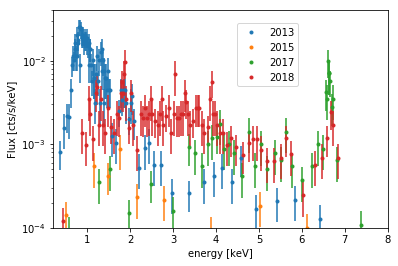

In [187]:
ui.set_analysis('energy')
ui.notice(.3, 9)
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
#ax.loglog()
ax.semilogy()
ax.set_xlim(.2, 8)
ax.set_ylim(1e-4, 0.04)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder], loc=(.55, .65))
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
fig.savefig(figdir + 'spectraA.pdf', bbox_inches='tight')

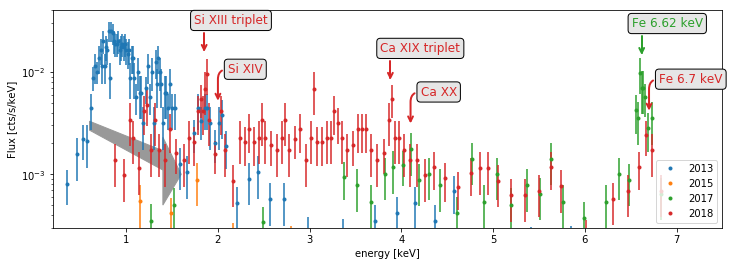

In [283]:
ui.set_analysis('energy')
ui.notice(.3, 9)
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
#ax.loglog()
ax.semilogy()
ax.set_xlim(.2, 7.5)
ax.set_ylim(3e-4, 0.04)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder], loc='lower right')
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
#ax.set_title("")
fig.set_size_inches(12, 4)

c = [l.get_c() for l in ax.get_lines()[1::2]]

def annotate(text, pos, offset, color):
    ax.annotate(text, color=color, fontsize='large',
            xy=pos, xycoords='data',
            xytext=offset, textcoords='offset points',
            bbox=dict(boxstyle="round", fc="0.9"),
            arrowprops=dict(arrowstyle="->", color=color, linewidth=2,
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"))

annotate('Fe 6.7 keV', (6.7, 4e-3), (10, 30), c[3])
annotate('Fe 6.62 keV', (6.62, 1.4e-2), (-10, 30), c[2])
annotate('Ca XIX triplet', (3.88, 8e-3), (-10, 30), c[3])
annotate('Ca XX', (4.1, 3e-3), (10, 30), c[3])
annotate('Si XIII triplet', (1.85, 1.5e-2), (-10, 30), c[3])
annotate('Si XIV', (2.0, 5e-3), (10, 30), c[3])

import matplotlib.patches as mpatches
arrow = mpatches.Arrow(.6, 3e-3, 1, -2e-3, width=3e-3, color='0.6')
ax.add_patch(arrow)


fig.savefig(figdir + 'spectraA.pdf', bbox_inches='tight')

In [250]:
l = ax.get_lines()[1::2][0]
l.get_c()

'#1f77b4'

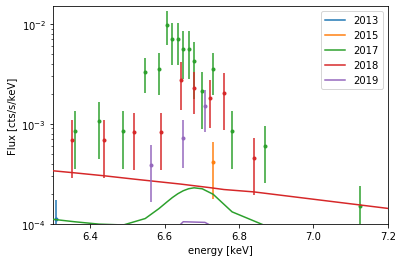

In [60]:
ui.set_analysis('energy')
ui.notice(.3, 9)

for i,j  in enumerate(plotorder):
    ui.group_counts(data['filestem'][j] + '_A', 3)
    ui.plot_fit(data['filestem'][j] + '_A', overplot=True, color=mplcolors[i])
   
ax = plt.gca()
ax.set_xlim(6.3, 7.2)
ax.set_ylim(1e-4, 0.015)
ax.semilogy()
ax.legend(ax.get_lines()[1::2], data['year'][plotorder])
ax.set_xlabel('energy [keV]')
ax.set_ylabel('Flux [cts/s/keV]')
fig = plt.gcf()
fig.savefig(figdir + 'spectraAFe.pdf', bbox_inches='tight')

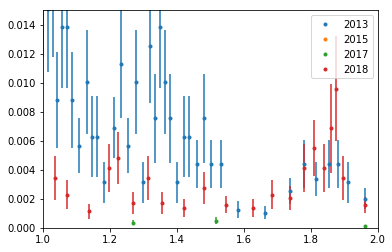

In [19]:
for i in ui.list_data_ids():
    ui.group_counts(i, 5)
    
for i in plotorder:
    ui.plot_data(21 + i, overplot=True)
    
ax = plt.gca()
ax.set_xlim(1, 2)
ax.set_ylim(0, 0.015)
ax.legend(ax.get_lines()[1::2], data['year'][plotorder])

In [54]:
import astropy.units as u
(3.8 * u.keV).to(u.Angstrom, equivalencies=u.spectral())

<Quantity 3.2627420367475564 Angstrom>

In [ ]:

# FIP values from NIST
# https://physics.nist.gov/cgi-bin/ASD/ie.pl?spectra=H-DS+i&units=1&at_num_out=on&el_name_out=on&shells_out=on&level_out=on&e_out=0&unc_out=on&biblio=on
'''
@Misc{NIST_ASD,
author = {A.~Kramida and {Yu.~Ralchenko} and
J.~Reader and {and NIST ASD Team}},
HOWPUBLISHED = {{NIST Atomic Spectra Database
(ver. 5.6.1), [Online]. Available:
{\tt{https://physics.nist.gov/asd}} [2018, November 30].
National Institute of Standards and Technology,
Gaithersburg, MD.}},
year = {2018},
}
'''


In [103]:
Av42.kT=0.8
Av42.norm=1e-5



In [224]:
ui.set_source(25, "xsphabs.Aa4 * (xsvapec.Av41 + xsvapec.Av42 + xsvapec.Av43)")

for elem in ['Fe', 'Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    getattr(Av41, elem).frozen = False
    getattr(Av42, elem).link = getattr(Av41, elem)
    getattr(Av43, elem).link = getattr(Av41, elem)

for elem in ['Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    getattr(Av41, elem).link = Av41.Fe

Av41.Fe.frozen=False
Av41.Ne.frozen=False
Av41.Ca.frozen=False
ui.unlink(Av41.Ca)
Av41.Fe = 1
Av41.Ne = 1
Av42.kT = 1.
Av42.norm = 0.001

Av43.norm = 0
Av43.norm.frozen = True
Av43.kT.frozen = True
#ui.ungroup(25)
ui.set_stat('cstat')
ui.notice(.3, 9.)
ui.ignore(None, 0.3)
ui.ignore(9., None)
ui.fit(25)

Dataset               = 25
Method                = levmar
Statistic             = cstat
Initial fit statistic = 601.33
Final fit statistic   = 166.96 at function evaluation 2312
Data points           = 159
Degrees of freedom    = 150
Probability [Q-value] = 0.162878
Reduced statistic     = 1.11307
Change in statistic   = 434.37
   Aa4.nH         4.03449      +/- 0.565606    
   Av41.kT        4.11851      +/- 0.62018     
   Av41.Ne        1000         +/- 0           
   Av41.Ca        87.434       +/- 0           
   Av41.Fe        34.681       +/- 0           
   Av41.norm      1.91331e-05  +/- 1.46669e-06 
   Av42.kT        0.115893     +/- 0.0175593   
   Av42.norm      0.00574287   +/- 0.0118507   
   scaleB.c0      0.0807644    +/- 0.00791614  


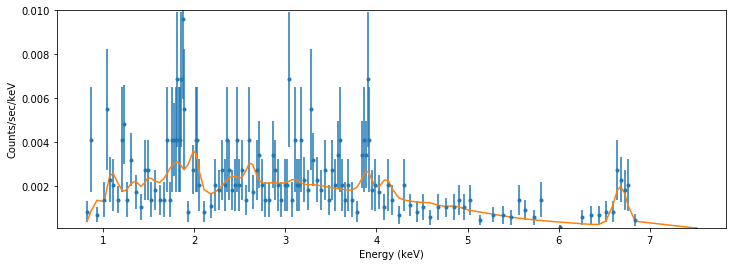

In [226]:
ui.set_analysis("energy")
ui.group_counts(25, 3)
ui.plot_fit(25)
ax = plt.gca()
#ax.loglog()
#ax.set_xlim(1.5, 7)
ax.set_ylim(1e-4, 0.01)
fig = plt.gcf()
ax.set_title("")
fig.set_size_inches(12, 4)
fig.savefig(figdir + 'spectraA18.pdf', bbox_inches='tight')

(6.3, 7)

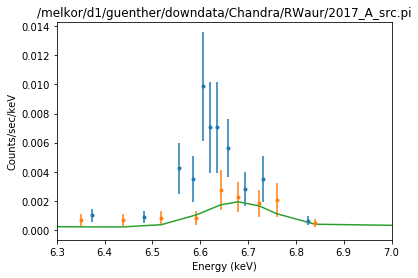

In [107]:
ui.group_counts(25, 3)
ui.plot_data(26)
ui.plot_fit(25, overplot=True)
ax = plt.gca()
ax.set_xlim(6.3, 7)
#ax.set_ylim(1e-4, 0.005)

In [112]:
ui.show_model(25, outfile=sys.stdout)

Model: 25
apply_rmf(apply_arf((49903.135062799 * ((xsphabs.Aa4 * ((xsvapec.Av41 + xsvapec.Av42) + xsvapec.Av43)) + 0.1458 * (((scale1d.scaleB * xsphabs.Ba4) * (xsvapec.Bv41 + xsvapec.Bv42)))))))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   Aa4.nH       thawed      4.64557            0       100000 10^22 atoms / cm^2
   Av41.kT      thawed      5.00617       0.0808       68.447        keV
   Av41.He      frozen            1            0         1000           
   Av41.C       frozen            1            0         1000           
   Av41.N       frozen            1            0         1000           
   Av41.O       frozen            1            0         1000           
   Av41.Ne      thawed      44.0975            0         1000           
   Av41.Mg      thawed          100            0         1000           
   Av41.Al      linked      3.80575            expr: Av41.Fe       

In [233]:
ui.set_source(25, "xsphabs.Aa4a * (xsvapec.Av41a + xsvapec.Av42a)")

for elem in ['Fe', 'Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
    #getattr(Av41a, elem).frozen = False
    getattr(Av42a, elem).link = getattr(Av41, elem)

#for elem in ['Mg', 'Al', 'Si', 'S', 'Ca', 'Ni']:
#    getattr(Av41, elem).link = Av41.Fe

Av41a.Fe.frozen=False
Av41a.Si.frozen=False
Av41a.Ca.frozen=False
Av42a.Fe.frozen=False
Av42a.Si.frozen=False
Av42a.Ca.frozen=False

ui.unlink(Av42a.Si)
ui.unlink(Av42a.Ca)
ui.unlink(Av42a.Fe)
Av41a.Fe = 1
Av41a.Ne = 1
Av41a.kT=.5
Av42a.kT = 2.
Av42a.norm = 0.001

#ui.ungroup(25)
ui.set_stat('cstat')
ui.notice(.3, 9.)
ui.ignore(None, 0.3)
ui.ignore(9., None)
ui.fit(25)

Dataset               = 25
Method                = levmar
Statistic             = cstat
Initial fit statistic = 1.95863e+07
Final fit statistic   = 166.406 at function evaluation 706
Data points           = 159
Degrees of freedom    = 147
Probability [Q-value] = 0.130508
Reduced statistic     = 1.13202
Change in statistic   = 1.95861e+07
   Aa4a.nH        3.99386      +/- 0.526575    
   Av41a.kT       0.600325     +/- 0.0732814   
   Av41a.Si       50.0949      +/- 0           
   Av41a.Ca       1000         +/- 0           
   Av41a.Fe       941.307      +/- 0           
   Av41a.norm     5.4537e-06   +/- 4.15052e-06 
   Av42a.kT       4.95232      +/- 0.939474    
   Av42a.Si       0            +/- 2.27769     
   Av42a.Ca       7.41625      +/- 5.06751     
   Av42a.Fe       2.92078      +/- 0.827329    
   Av42a.norm     0.000252551  +/- 3.47916e-05 
   scaleB.c0      0.0827227    +/- 0.00801931  


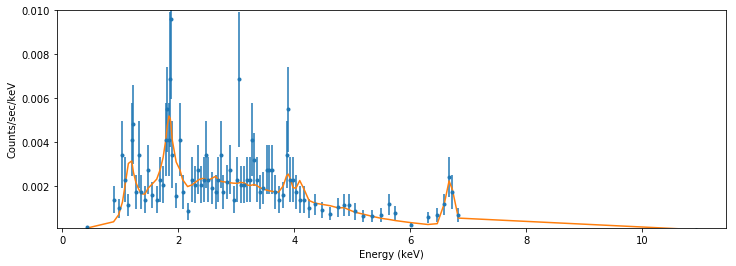

In [235]:
ui.set_analysis("energy")
ui.group_counts(25, 5)
ui.plot_fit(25)
ax = plt.gca()
#ax.loglog()
#ax.set_xlim(1.5, 7)
ax.set_ylim(1e-4, 0.01)
fig = plt.gcf()
ax.set_title("")
fig.set_size_inches(12, 4)

# 2018 flare vs non-flare

In [138]:
ui.load_data(100, datadir + '21176_A_grp.pi')
ui.load_data(101, datadir + '21176_A_noflare_grp.pi')
ui.load_data(102, datadir + '21176_A_flare_grp.pi')

read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A.rmf
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_bkg.rmf
read background file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_bkg.pi
read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_noflare.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_noflare.rmf
read ARF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_noflare_bkg.arf
read RMF (background) file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_noflare_bkg.rmf
read background file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_noflare_bkg.pi
read ARF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_flare.corr.arf
read RMF file /melkor/d1/guenther/downdata/Chandra/RWaur/21176_A_flare.rmf
read ARF (backgro

In [139]:

for i in range(0, 3):
    ui.ungroup(100 + i)
    ui.ignore_bad(100 + i)

ui.set_analysis("energy")
ui.ignore(None, 0.3)
ui.ignore(9., None)

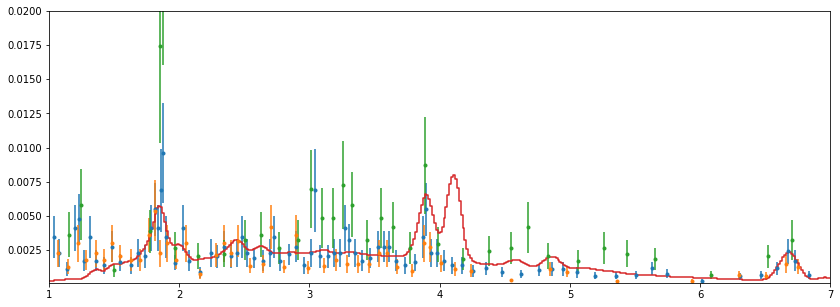

In [197]:

for i in range(0, 3):
    ui.set_analysis("energy")
    ui.group_counts(100+i, 5)
    ui.ignore(None, 0.3)
    ui.ignore(9., None)

    ui.plot_data(100+i, overplot=True)
    
ui.plot_model(25, overplot=True)

ax = plt.gca()
#ax.loglog()
#ax.set_xlim(.6, 8)
#ax.set_ylim(1e-4, 0.02)
ax.set_xlim(1, 7)
ax.set_ylim(1e-4, 0.02)
fig = plt.gcf()
fig.set_size_inches(14, 5)